In [6]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

from batch import ResBatch
from dataset import Dataset, DatasetIndex

In [ ]:
ix = DatasetIndex(range(65000))
dataset = Dataset(ix, batch_class=ResBatch)
dataset.cv_split([0.8, 0.2])

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
session = tf.Session()
session.run(tf.global_variables_initializer())

In [10]:
train_loss_fr = []
train_acc_fr = []
train_loss_n = []
train_acc_n = []

train_pipeline = (dataset.train.
                  p.
                  load(src='./../MNIST_data', fmt='blosc').
                  train_freez(sess, train_loss_fr, train_acc_fr))
                  #train_res(session, train_loss_n, train_acc_n))
train_2 = (dataset.train.
          p.
          load(src='./../MNIST_data', fmt='blosc').
          train_res(session, train_loss_n, train_acc_n))

In [16]:
MAX_ITER = 500

for curr_iter in tqn(range(1, MAX_ITER + 1)):
    #training model
    train_pipeline.next_batch(50, n_epochs=None)
    

In [11]:
MAX_ITER = 500

for curr_iter in tqn(range(1, MAX_ITER + 1)):
    #training model
    train_2.next_batch(50, n_epochs=None)
    

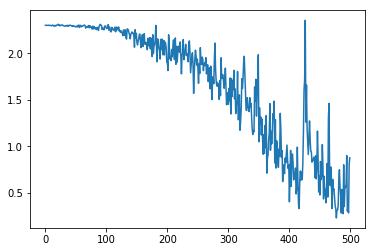

In [13]:
plt.plot(train_loss_n)

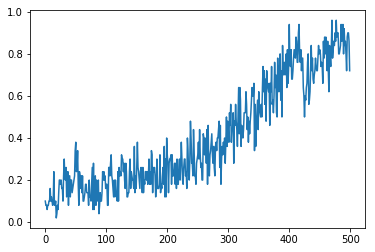

In [14]:
plt.plot(train_acc_n)

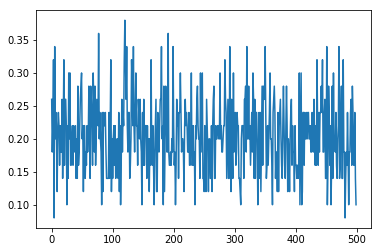

In [17]:
plt.plot(train_acc_fr)

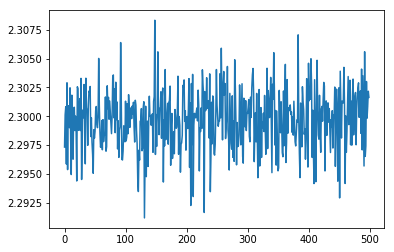

In [18]:
plt.plot(train_loss_fr)

In [ ]:
src = './../MNIST_data'
with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    images = blosc.unpack_array(file.read()).reshape(-1, 28, 28)
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    labels = blosc.unpack_array(file.read())

In [ ]:
def create_train(opt, src, global_step, loss, it):
    def learning_rate(last, src):
        last = int(last)
        bound = list(np.linspace(0, last, len(range(2, last+1)), dtype=np.int32))
        values = [0.5 * 0.1/last * (1 + np.cos(np.pi * i / last)) for i in range(2, last+1)]
        var = [i for i in tf.trainable_variables() if src in i.name or 'dense' in i.name]
        
        return bound, values, var
    
    b, v, var = learning_rate(it, src)
    learning_rate = tf.train.piecewise_constant(global_step, b, v)
    
    return opt(learning_rate, 0.9, use_nesterov=True).minimize(loss, global_step, var)

In [ ]:
def conv_block(input_tensor, kernel, filters, name, strides=(2, 2)):
    
    filters1, filters2, filters3 = filters
    x = tf.layers.conv2d(input_tensor, filters1, (1, 1), strides, name='convo' + name, activation=tf.nn.relu,\
                         kernel_initializer=xavier())
    
    x = tf.layers.conv2d(x, filters2, kernel, name='convt' + name, activation=tf.nn.relu, padding='SAME',\
                         kernel_initializer=xavier())
    
    x = tf.layers.conv2d(x, filters3, (1, 1), name='convtr' + name,\
                         kernel_initializer=xavier())
    
    shortcut = tf.layers.conv2d(input_tensor, filters3, (1, 1), strides, name='short' + name, \
                         kernel_initializer=xavier())
    x = tf.concat([x, shortcut], axis=1)
    x = tf.nn.relu(x)
    return x

In [ ]:
def identity_block(input_tensor, kernel, filters, name):
    
    filters1, filters2, filters3 = filters
    x = tf.layers.conv2d(input_tensor, filters1, (1, 1), name='convo' + name, activation=tf.nn.relu,\
                         kernel_initializer=xavier())
    
    x = tf.layers.conv2d(x, filters2, kernel, name='convt' + name, activation=tf.nn.relu, padding='SAME',\
                         kernel_initializer=xavier())
    
    x = tf.layers.conv2d(x, filters3, (1, 1), name='convtr' + name,\
                         kernel_initializer=xavier())
    
  
    x = tf.concat([x, input_tensor], axis=1)
    x = tf.nn.relu(x)
    return x

In [ ]:

x_f = tf.placeholder(tf.float32, shape=[None, 784])

x_f_to_tens = tf.reshape(x_f, shape=[-1, 28, 28, 1])

net = tf.layers.conv2d(x_f_to_tens, 16, (7, 7), strides=(2, 2), padding='SAME', activation=tf.nn.relu, \
                       kernel_initializer=xavier(), name='7')
net = tf.layers.max_pooling2d(net, (2, 2),(2, 2))

net = conv_block(net, 3, [32, 32, 128], name='6', strides=(1, 1))
net = identity_block(net, 3, [32, 32, 128], name='5')
net = identity_block(net, 3, [32, 32, 128], name='4')

net = conv_block(net, 3, [64, 64, 256], name='3', strides=(1, 1))
net = identity_block(net, 3, [64, 64, 256], name='2')
net = identity_block(net, 3, [64, 64, 256], name='1')

net = tf.layers.average_pooling2d(net, (7, 7), strides=(1, 1))
net = tf.contrib.layers.flatten(net)

with tf.variable_scope('dense'):
    net = tf.layers.dense(net, 10)

prob = tf.nn.softmax(net)
y = tf.placeholder(tf.float32, [None, 10])
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=net, labels=y), name='loss')

it = 300
train = []
global_steps = []
for i in tqn(range(1, 8)):
    global_steps.append(tf.Variable(0, trainable=False))
    train.append(create_train(tf.train.MomentumOptimizer, str(i), \
                              global_steps[-1], loss, it*(i/10 + 0.5)))


lables_hat = tf.cast(tf.argmax(net, axis=1), tf.float32, name='lables_hat')
lables = tf.cast(tf.argmax(y, axis=1), tf.float32, name='lables')
accuracy = tf.reduce_mean(tf.cast(tf.equal(lables_hat, lables), tf.float32, name='accuracy'))

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

los, acc = [], []
var_i = []
for i in tqn(range(1, 300)):
    var, a, b = sess.run([train, tf.global_variables()[0], loss, accuracy],feed_dict={x_f:images[:100].reshape(-1, 784),
                                                                          y:labels[:100].reshape(-1,10)})[-3:]
    var_i.append(var)
    los.append(a)
    acc.append(b)

In [ ]:
plt.plot(acc)

In [ ]:

x1 = tf.placeholder(tf.float32, shape=[None, 784])

x1_to_tens = tf.reshape(x1, shape=[-1, 28, 28, 1])

net1 = tf.layers.conv2d(x1_to_tens, 64, (7, 7), strides=(2, 2), padding='SAME', activation=tf.nn.relu, \
                       kernel_initializer=xavier(), name='11')
net1 = tf.layers.max_pooling2d(net1, (2, 2),(2, 2))

net1 = conv_block(net1, 3, [64, 64, 256], name='22', strides=(1, 1))

net1 = identity_block(net1, 3, [64, 64, 256], name='33')
net1 = identity_block(net1, 3, [64, 64, 256], name='43')

net1 = conv_block(net1, 3, [128, 128, 512], name='53', strides=(1, 1))
net1 = identity_block(net1, 3, [128, 128, 512], name='63')
net1 = identity_block(net1, 3, [128, 128, 512], name='73')

net1 = tf.layers.average_pooling2d(net1, (7, 7), strides=(1, 1))
net1 = tf.contrib.layers.flatten(net1)

with tf.variable_scope('dense3'):
    net1 = tf.layers.dense(net1, 10)
print(net1.get_shape().as_list())
prob1 = tf.nn.softmax(net1)
y1 = tf.placeholder(tf.float32, [None, 10])
loss1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=net1, labels=y1), name='loss3')

train1 = tf.train.MomentumOptimizer(0.01, 0.9, use_nesterov=True).minimize(loss1)
lables_hat1 = tf.cast(tf.argmax(net1, axis=1), tf.float32, name='lables_3at')
lables1 = tf.cast(tf.argmax(y1, axis=1), tf.float32, name='labl3es')

accuracy1 = tf.reduce_mean(tf.cast(tf.equal(lables_hat1, lables1), tf.float32, name='a3ccuracy'))


In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

los1, acc1 = [], []
for i in tqn(range(1, 300)):
    var, a, b = sess.run([train1, loss1, accuracy1],feed_dict={x1:images[:100].reshape(-1, 784),
                                                                          y1:labels[:100].reshape(-1,10)})[-3:]
    los1.append(a)
    acc1.append(b)

In [ ]:
plt.figure(figsize = (10, 8))
plt.grid()
plt.title('Loss graph', fontsize=18)
plt.plot(los1, label='no FreezeOut')
plt.plot(los, label='FreezeOut')
plt.xlabel('iteration', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.legend(fontsize=15)

In [ ]:
plt.figure(figsize = (10, 8))
plt.grid()
plt.title('Accuracy graph', fontsize=18)
plt.plot(acc1, label='no FreezeOut')
plt.plot(acc, label='FreezeOut')
plt.xlabel('iteration', fontsize=18)
plt.ylabel('accuracy', fontsize=18)
plt.legend(fontsize=15)